In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from concurrent.futures import ThreadPoolExecutor, as_completed
import dask.dataframe as dd
import sys

sys.path.append("../../scripts")
%aimport initial_map
%aimport map_refiner
%aimport complexity
%aimport finder
%aimport preprocess
%aimport complexity
    
import glob
from tqdm import tqdm  # progress bar

# Test flexible orders on CC NKX2-2 Step 1

In [9]:
# mapper = BarcodeMapper(seq_file = ['../../data/Staller_Tl4s1_MVS_0035_I1TTGTCACCAA_CGCACGAACA_S326.fastq.gz.assembled.fastq'],
#                         design_file_path = "../../data/DNA_Tiles_nkx2_2.txt",
#                         bc_names = ["ADBC2", "HawkBCs", "RTBC", "AD"],
#                         preceders = ["CTCGAGATAACTTCGTATAATGTATGCTAT", "GAGCTCGCTAGC", "GGCCGGCCATAGGGCCCC", "CACCATG"],
#                         posts = ["GGCCGGCCATAGGGCCCC", "CTCGAGATAA", "GCGGTCCA", "GGATCCG"],
#                         lengths = [6, 9, 16, 162],
#                       reverse_complement=False)
# mapped_df = mapper.create_map()
# preprocess.save_parquet(mapped_df, '../output/CC_nkx2_2.parquet')
# mapped_df.head()

In [10]:
step1_ADBC2 = finder.Barcode(name = "ADBC2",
                       preceder = "CTCGAGATAACTTCGTATAATGTATGCTAT",
                       post = "GGCCGGCCATAGGGCCCC",
                       length = 6)

step1_HawkBCs = finder.Barcode(name = "HawkBCs",
                       preceder = "GAGCTCGCTAGC",
                       post = "CTCGAGATAA",
                       length = 9)

step1_RTBC = finder.Barcode(name = "RTBC",
                       preceder = "GGCCGGCCATAGGGCCCC",
                       post = "GCGGTCCA",
                       length = 16)

step1_AD = finder.Barcode(name = "AD",
                       preceder = "CACCATG",
                       post = "GGATCCG",
                       length = 162)

In [41]:
threshold_last_refiner = map_refiner.MapRefiner(db_path = "../../duckdb/NKX2-2_full.db",
                     bc_objects = [step1_ADBC2, step1_HawkBCs, step1_RTBC, step1_AD],
                     column_pairs = [(("ADBC2", "HawkBCs"), "AD"), ( "RTBC", ("ADBC2", "HawkBCs"))],
                        design_check = True, 
                         reads_threshold = 5,
                         map_order = ['barcode_exists', "quality_designed", "grouped", "unique_target", "thresholded"],
                        step_name = "step1",
                                should_check_exists = False, plot_histograms = False,
                                min_fraction = 0.9,
                                descriptor = "threshold_last")
threshold_last_refiner.refine_map_from_db()

Base prefix (stable across descriptors): step1_ADBC2_HawkBCs_RTBC_AD_
Full prefix for this instance: step1_ADBC2_HawkBCs_RTBC_AD_threshold_last_

Using the following step order:
1. initial
2. barcode_exists
3. quality_designed
4. grouped
5. unique_target
6. thresholded



In [43]:
# threshold_last_refiner = MapRefiner(db_path = "../../duckdb/CC_nkx2_2_threshold_last",
#                         bc_objects = [step1_ADBC2, step1_HawkBCs, step1_RTBC, step1_AD],
#                      column_pairs = [("AD", ("ADBC2", "HawkBCs")), (("ADBC2", "HawkBCs"), "RTBC")],
#                      map_order = ["initial", "quality_designed", "grouped", "unique_target", "thresholded"])
# # threshold_last_refiner.refine_map_from_parquet("../../output/CC_nkx2_2.parquet/*")
# # threshold_last_refiner.save_loss_table()

In [44]:
threshold_first_refiner = map_refiner.MapRefiner(db_path = "../../duckdb/NKX2-2_full.db",
                     bc_objects = [step1_ADBC2, step1_HawkBCs, step1_RTBC, step1_AD],
                     column_pairs = [(("ADBC2", "HawkBCs"), "AD"), ( "RTBC", ("ADBC2", "HawkBCs"))],
                        design_check = True, 
                         reads_threshold = 5,
                         map_order = ['barcode_exists', "quality_designed", "grouped", "thresholded", "unique_target"],
                        step_name = "step1",
                                should_check_exists = False, plot_histograms = False,
                                min_fraction = 0.9,
                                descriptor = "threshold_first")
threshold_first_refiner

Base prefix (stable across descriptors): step1_ADBC2_HawkBCs_RTBC_AD_
Full prefix for this instance: step1_ADBC2_HawkBCs_RTBC_AD_threshold_first_

Using the following step order:
1. initial
2. barcode_exists
3. quality_designed
4. grouped
5. thresholded
6. unique_target



In [45]:
threshold_first_refiner.refine_map_from_db()

Removing rows with null or empty barcodes (excluding AD)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 2.60 seconds.

Filtering to quality and designed...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 2.53 seconds.

Grouping step1_ADBC2_HawkBCs_RTBC_AD_threshold_first_quality_designed...
Done in 0.23 seconds.

Thresholding...
Using reads threshold of 5.
Done in 0.01 seconds.

Filtering so that at least 90% of reads come from the most abundant target...
	Processing mapping 1: ADBC2 || '-' || HawkBCs → AD
	Processing mapping 2: RTBC → ADBC2 || '-' || HawkBCs
Created filtered table: step1_ADBC2_HawkBCs_RTBC_AD_threshold_first_unique_target
Done in 0.03 seconds.

Done.


In [46]:
# threshold_first_refiner = MapRefiner(db_path = "../../duckdb/CC_nkx2_2_threshold_first",
#                         bc_objects = [step1_ADBC2, step1_HawkBCs, step1_RTBC, step1_AD],
#                      column_pairs = [("AD", ("ADBC2", "HawkBCs")), (("ADBC2", "HawkBCs"), "RTBC")],
#                      map_order = ["initial", "quality_designed", "grouped", "thresholded", "unique_target"])
# # threshold_first_refiner.refine_map_from_parquet("../../output/CC_nkx2_2.parquet/*")
# # threshold_first_refiner.save_loss_table()

In [47]:
# sk_order_refiner = MapRefiner(db_path = "../../duckdb/CC_nkx2_2_sk_order",
#                         bc_objects = [step1_ADBC2, step1_HawkBCs, step1_RTBC, step1_AD],
#                      column_pairs = [("AD", ("ADBC2", "HawkBCs")), (("ADBC2", "HawkBCs"), "RTBC")],
#                      map_order = ["initial", "grouped", "thresholded", "unique_target", "quality_designed"])
# # sk_order_refiner.refine_map_from_parquet("../../output/CC_nkx2_2.parquet/*")
# # sk_order_refiner.save_loss_table()

In [50]:
sk_refiner = map_refiner.MapRefiner(db_path = "../../duckdb/NKX2-2_full-clustered.db",
                     bc_objects = [step1_ADBC2, step1_HawkBCs, step1_RTBC, step1_AD],
                     column_pairs = [(("ADBC2", "HawkBCs"), "AD"), ( "RTBC", ("ADBC2", "HawkBCs"))],
                        design_check = True, 
                         reads_threshold = 5,
                        map_order = ['grouped', 'thresholded', 'unique_target', 'quality_designed'],
                        step_name = "step1",
                                should_check_exists = True, plot_histograms = False,
                                min_fraction = 0.9,
                                descriptor = "sk_refiner")
sk_refiner

Base prefix (stable across descriptors): step1_ADBC2_HawkBCs_RTBC_AD_
Full prefix for this instance: step1_ADBC2_HawkBCs_RTBC_AD_sk_refiner_

Using the following step order:
1. initial
2. grouped
3. thresholded
4. unique_target
5. quality_designed



In [51]:
sk_refiner.refine_map_from_db()

Grouping step1_ADBC2_HawkBCs_RTBC_AD_initial...
Skipping — table step1_ADBC2_HawkBCs_RTBC_AD_initial_grouped already exists and is initial/grouped.
Done in 0.00 seconds.

Thresholding...
Using reads threshold of 5.
Done in 0.03 seconds.

Filtering so that at least 90% of reads come from the most abundant target...
	Processing mapping 1: ADBC2 || '-' || HawkBCs → AD
	Processing mapping 2: RTBC → ADBC2 || '-' || HawkBCs
Created filtered table: step1_ADBC2_HawkBCs_RTBC_AD_sk_refiner_unique_target
Done in 0.04 seconds.

Filtering to quality and designed...
Done in 0.01 seconds.

Done.


Saved loss summary table as 'step1_ADBC2_HawkBCs_RTBC_AD_threshold_last_loss_summary'
Done in 0.06 seconds.



<Axes: xlabel='Read Count (Unique, Total)', ylabel='Map Step'>

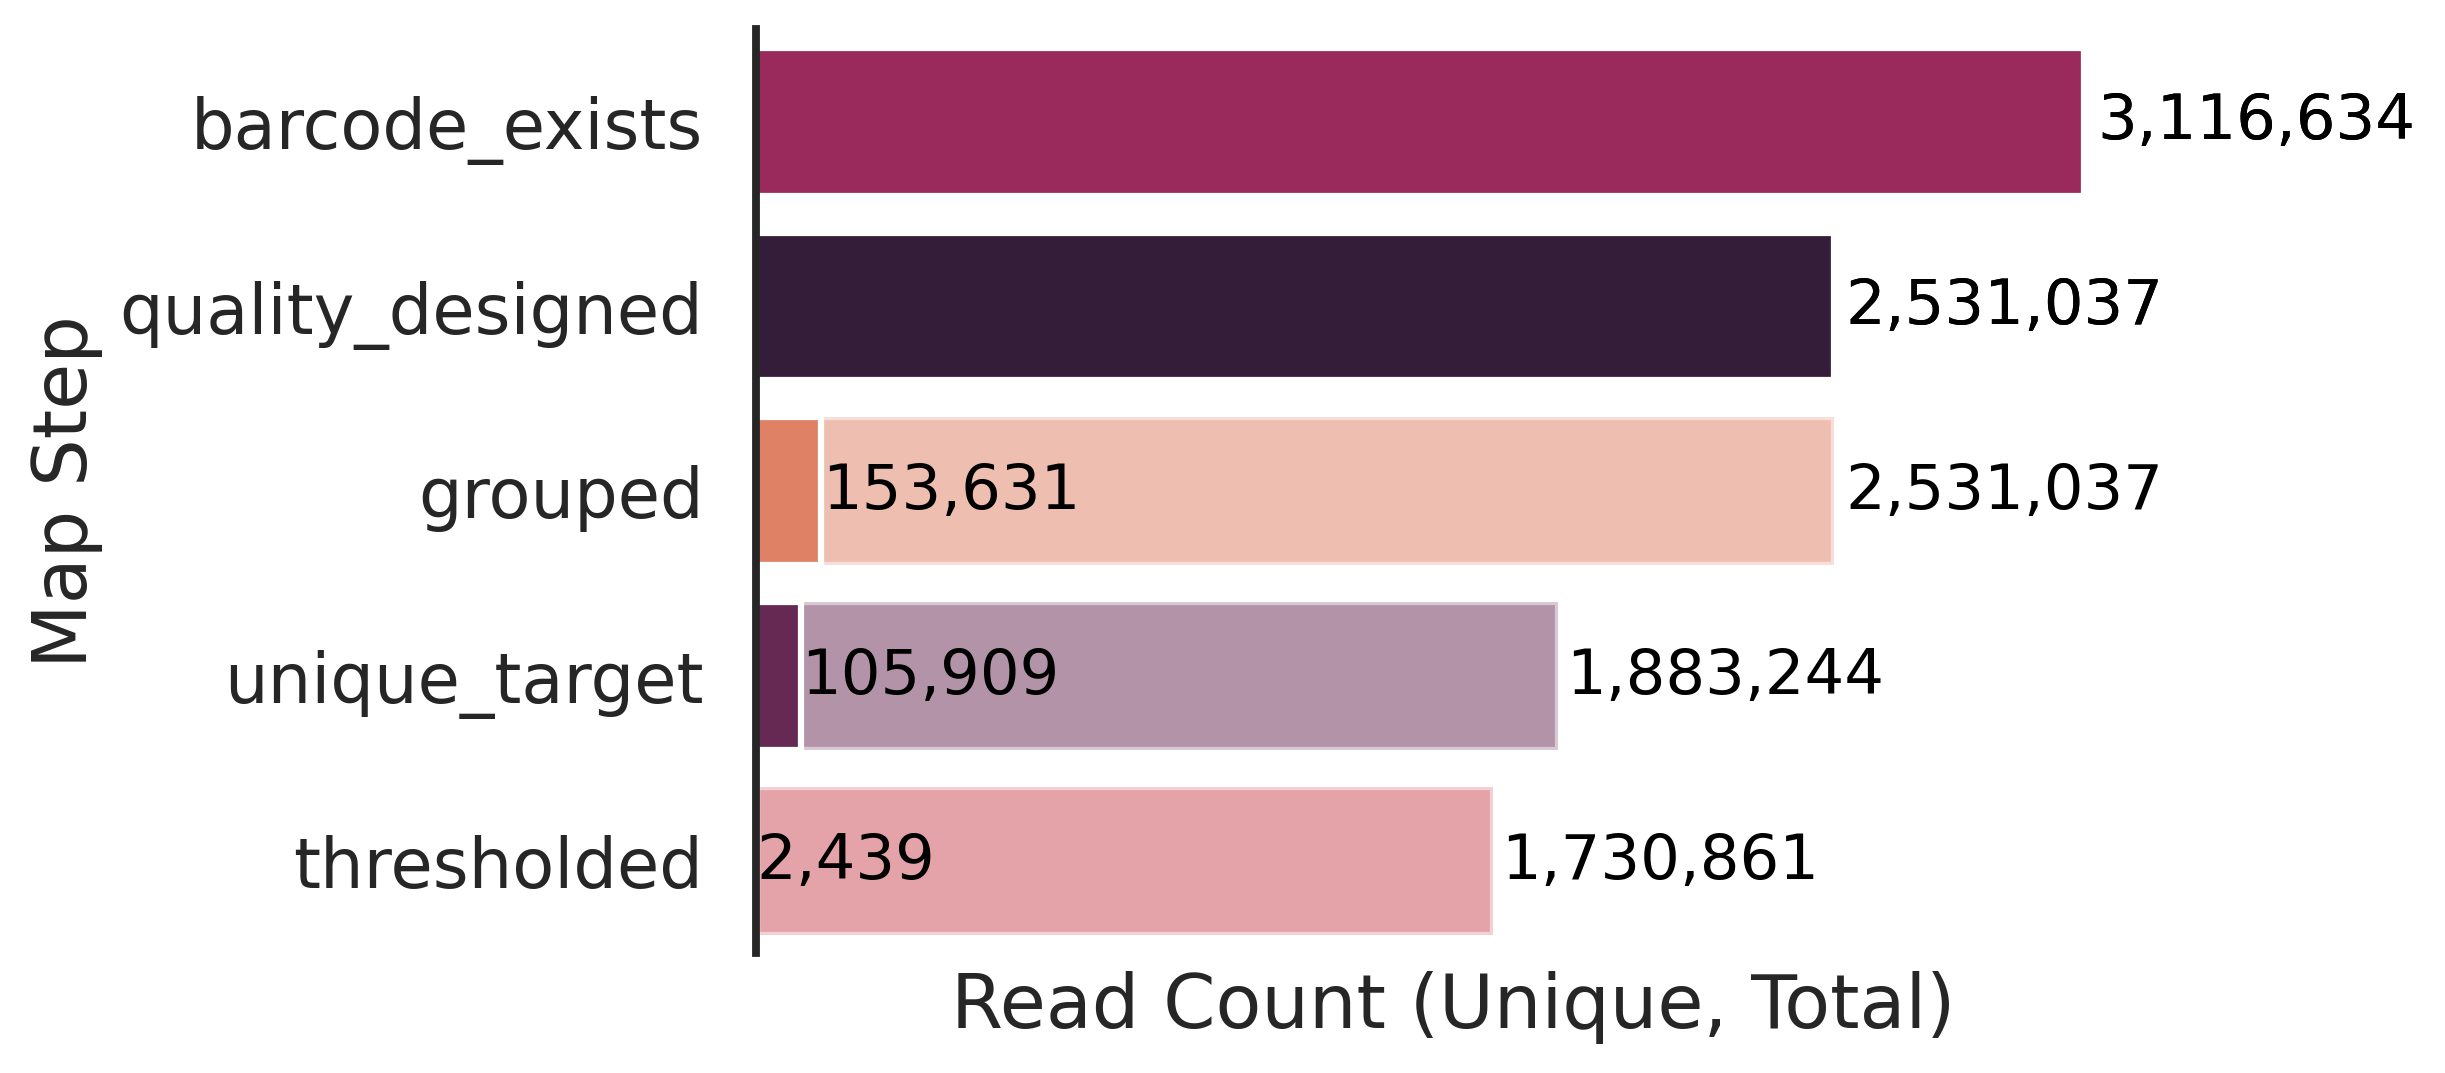

In [54]:
threshold_last_refiner.plot_loss()

Saved loss summary table as 'step1_ADBC2_HawkBCs_RTBC_AD_threshold_last_loss_summary'
Done in 0.08 seconds.

Saved loss summary table as 'step1_ADBC2_HawkBCs_RTBC_AD_threshold_first_loss_summary'
Done in 0.05 seconds.

Saved loss summary table as 'step1_ADBC2_HawkBCs_RTBC_AD_sk_refiner_loss_summary'
Done in 0.05 seconds.



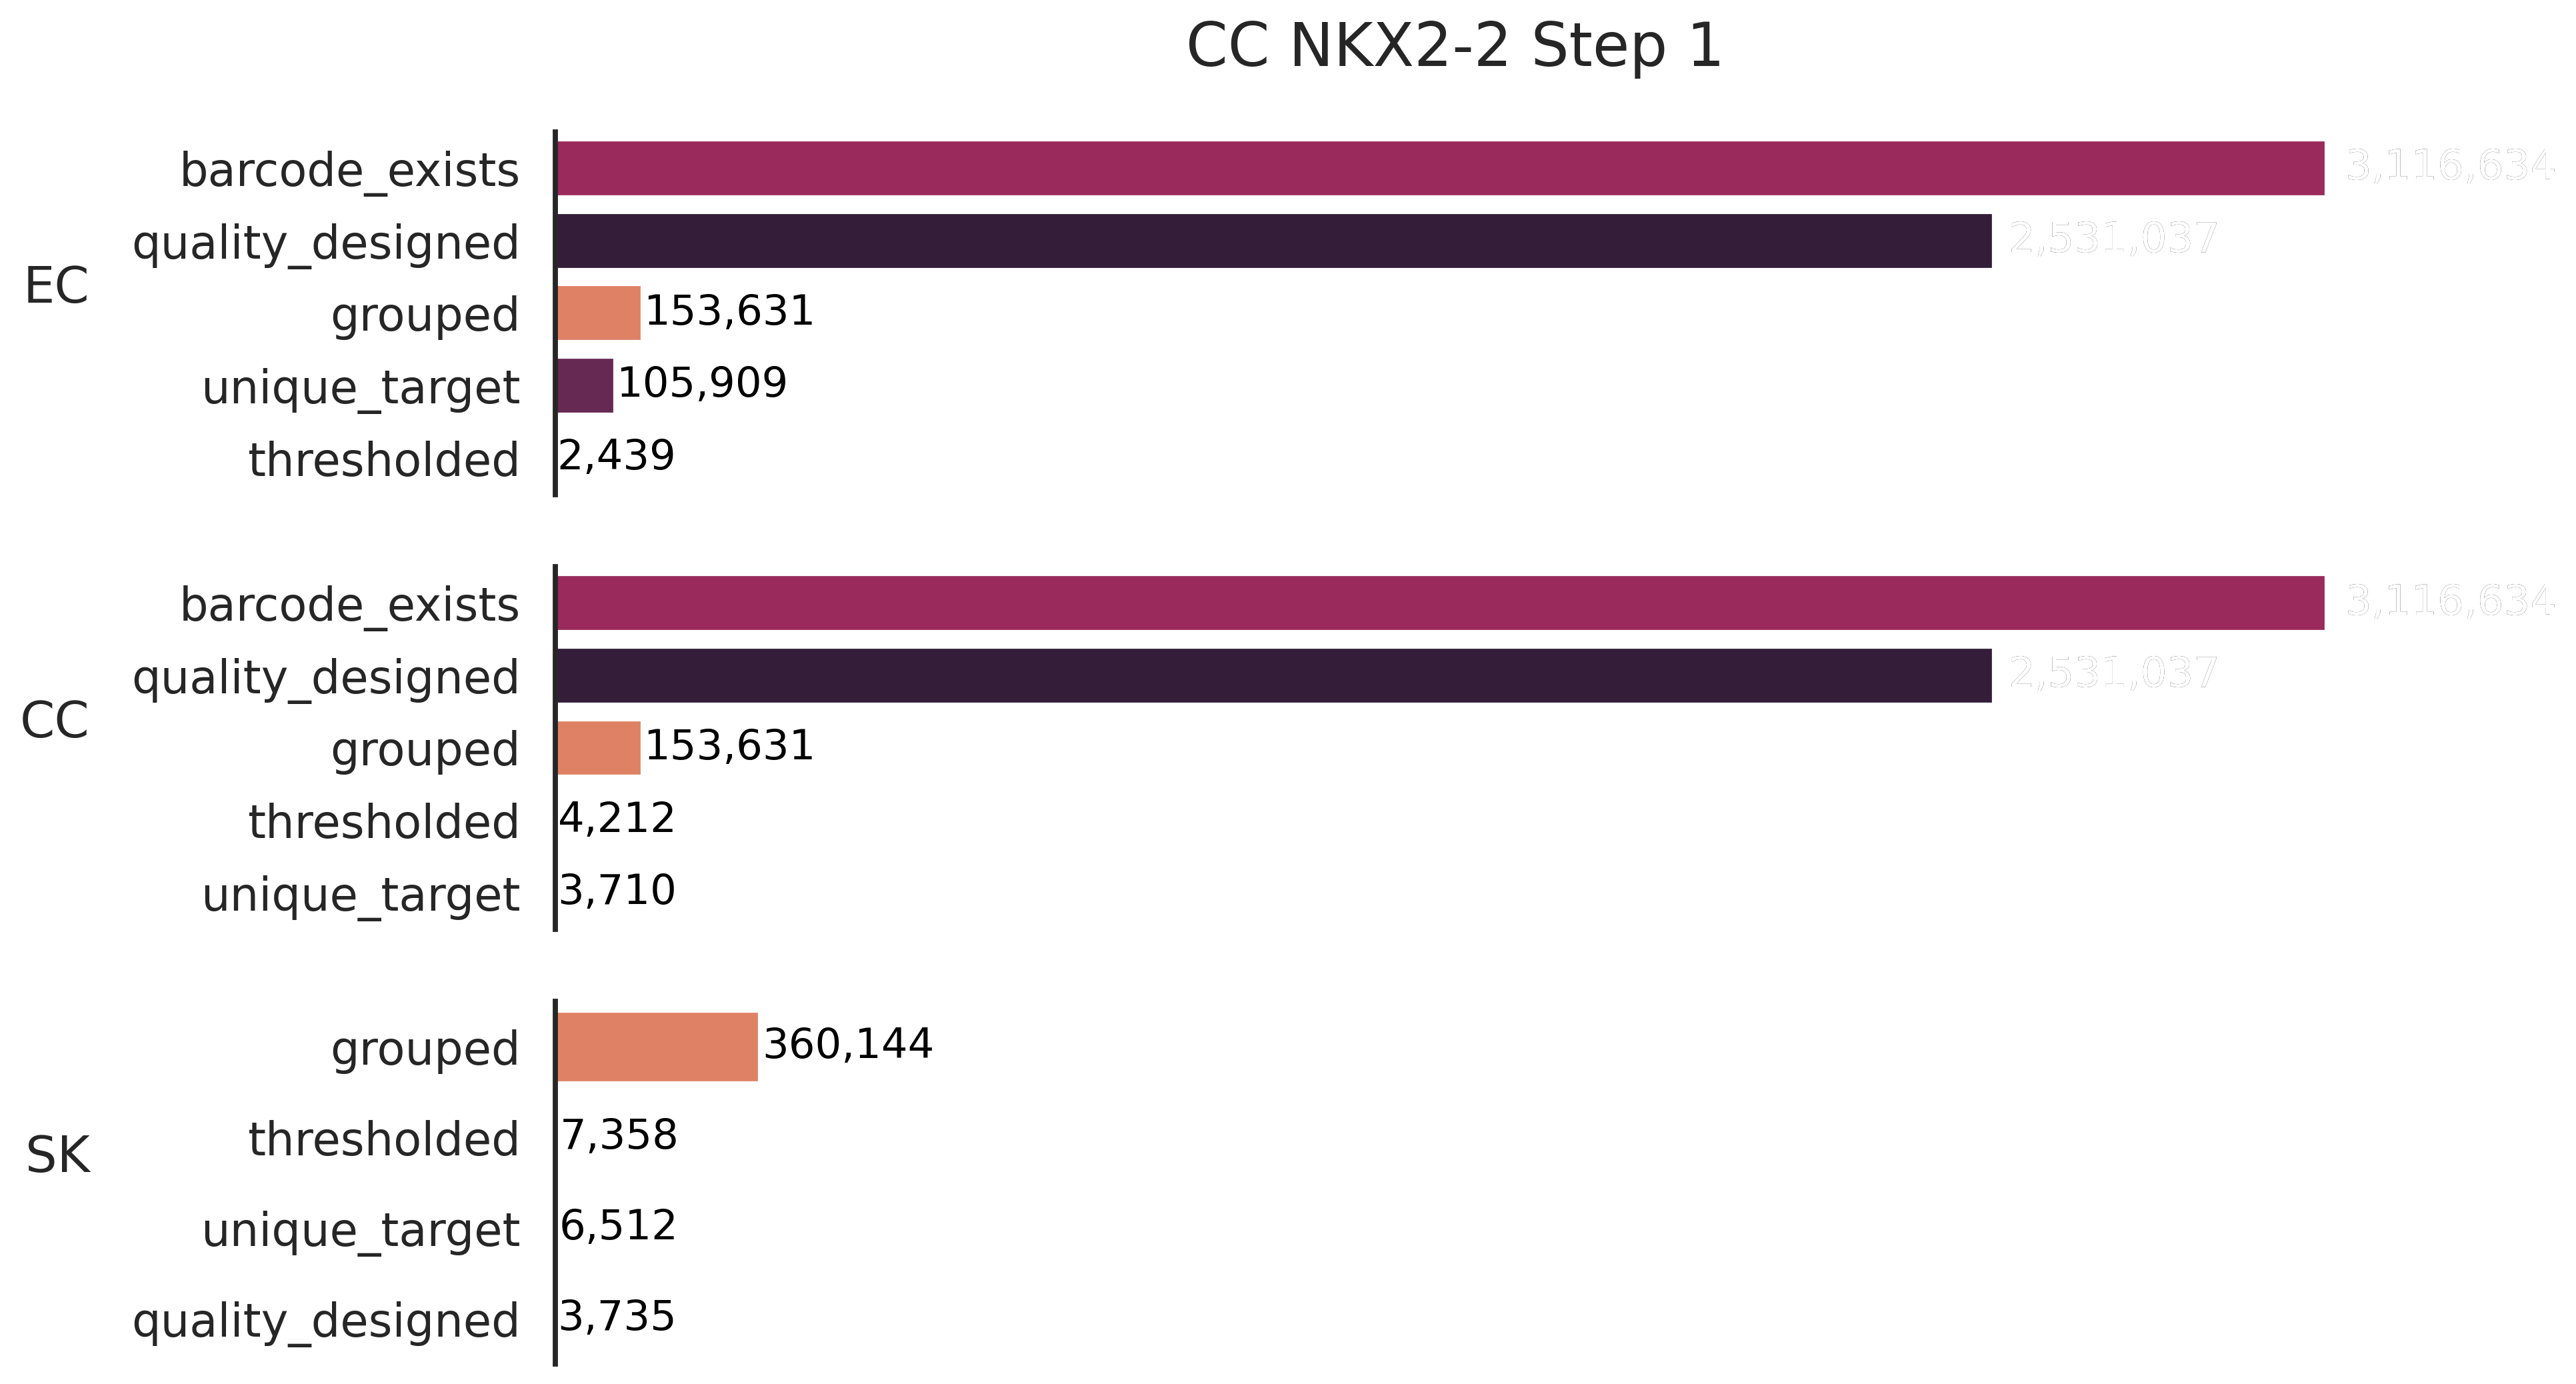

In [52]:
fig, axs = plt.subplots(3,1, figsize = (12,8), dpi = 300, sharex = True)

sns.set_context('talk')

threshold_last_refiner.plot_loss(ax = axs[0], show_background=False)
axs[0].set_ylabel("EC", rotation = 0, ha = 'right', labelpad = 15)

threshold_first_refiner.plot_loss(ax = axs[1], show_background=False)
axs[1].set_ylabel("CC", rotation = 0, ha = 'right', labelpad = 15)

sk_refiner.plot_loss(ax = axs[2], show_background=False)
axs[2].set_ylabel("SK", rotation = 0, ha = 'right', labelpad = 15)

fig.suptitle("CC NKX2-2 Step 1", y = 0.95)

for ax in axs:
    ax.set_xlabel("")

Saved loss summary table as 'step1_ADBC2_HawkBCs_RTBC_AD_threshold_last_loss_summary'
Done in 0.06 seconds.

Saved loss summary table as 'step1_ADBC2_HawkBCs_RTBC_AD_threshold_first_loss_summary'
Done in 0.06 seconds.

Saved loss summary table as 'step1_ADBC2_HawkBCs_RTBC_AD_sk_refiner_loss_summary'
Done in 0.05 seconds.



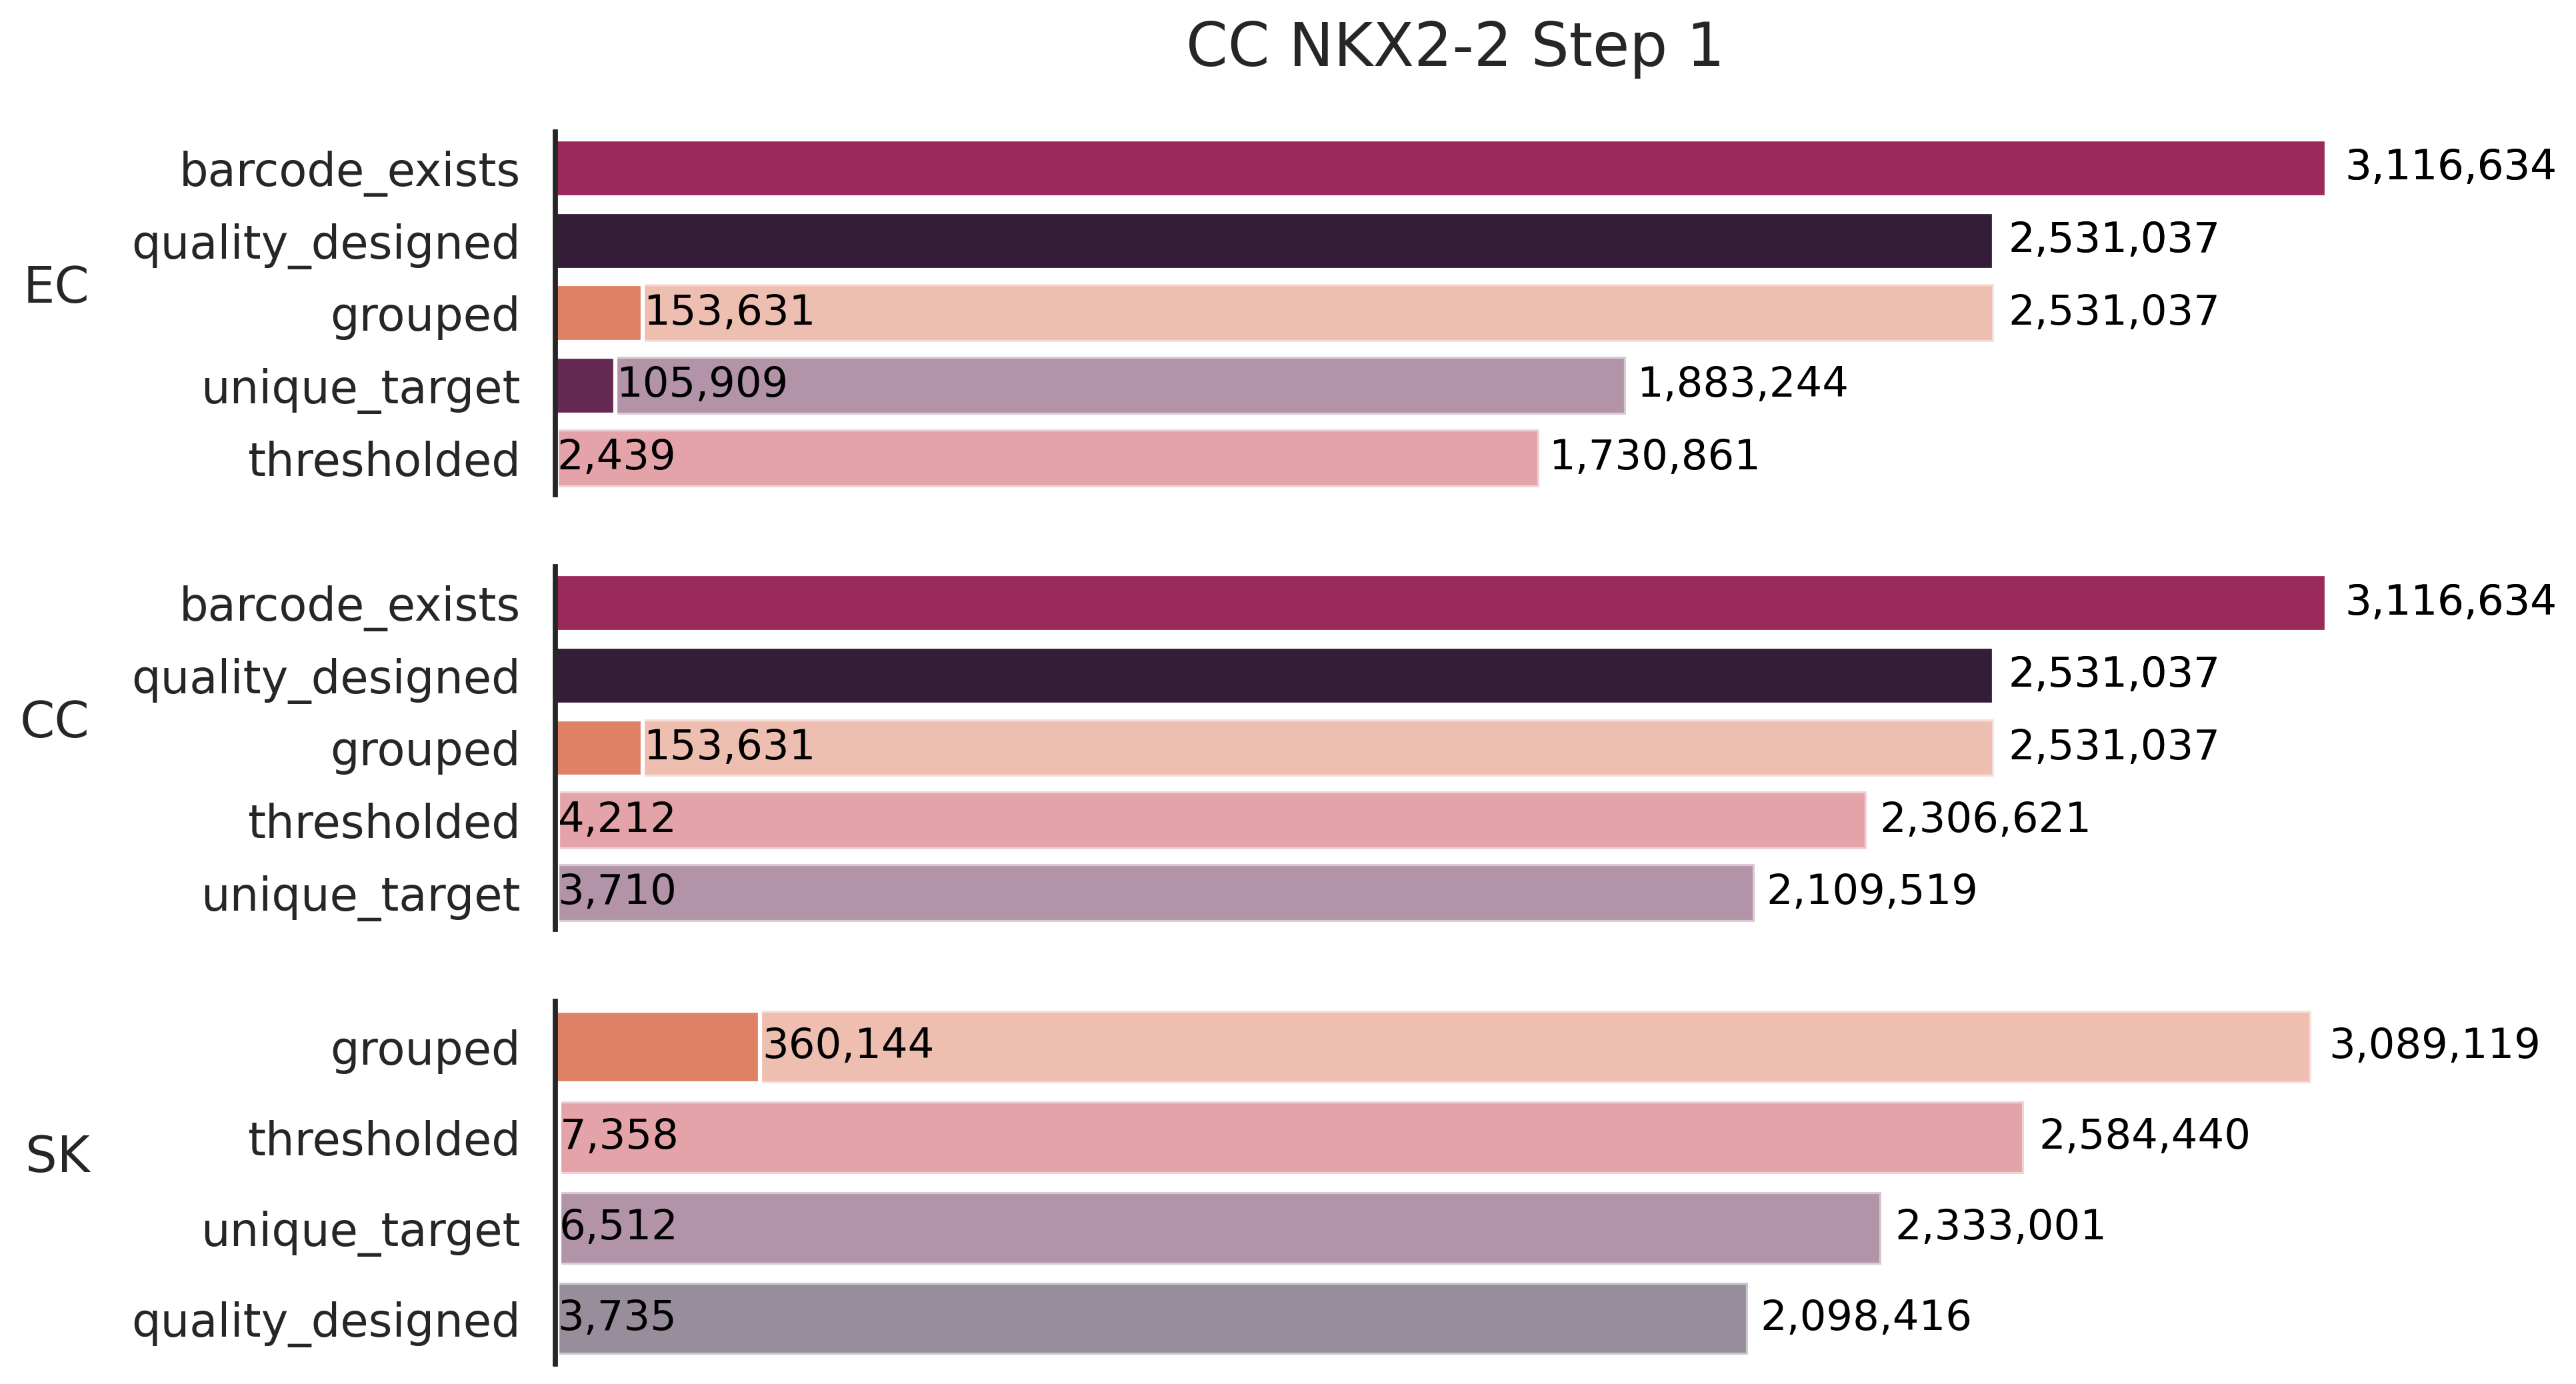

In [53]:
fig, axs = plt.subplots(3,1, figsize = (12,8), dpi = 300, sharex = True)

sns.set_context('talk')

threshold_last_refiner.plot_loss(ax = axs[0])
axs[0].set_ylabel("EC", rotation = 0, ha = 'right', labelpad = 15)

threshold_first_refiner.plot_loss(ax = axs[1])
axs[1].set_ylabel("CC", rotation = 0, ha = 'right', labelpad = 15)

sk_refiner.plot_loss(ax = axs[2])
axs[2].set_ylabel("SK", rotation = 0, ha = 'right', labelpad = 15)

fig.suptitle("CC NKX2-2 Step 1", y = 0.95)

for ax in axs:
    ax.set_xlabel("")

# Test flexible orders on EC Step 1

In [13]:
# Temp

EC_AD = finder.Barcode(name = "AD",
                       preceder = "",
                       post = "",
                       length = 0)

EC_AD_BC = finder.Barcode(name = "AD_BC",
                       preceder = "",
                       post = "",
                       length = 0)

EC_RPTR_BC = finder.Barcode(name = "RPTR_BC",
                       preceder = "",
                       post = "",
                       length = 0)


In [14]:
EC_threshold_last_refiner = MapRefiner(db_path = "../../duckdb/EC_threshold_last_refiner",
                                                               bc_objects = [EC_AD, EC_AD_BC, EC_RPTR_BC],
                     reads_threshold = 50,
                     column_pairs = [("AD", "AD_BC"), ("AD_BC", "RPTR_BC")],
                     map_order = ["initial", "quality_designed", "grouped", "unique_target", "thresholded"])
# EC_threshold_last_refiner.refine_map_from_parquet('/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/SK_CURRENT_A10_1_tbcRAW_v2.parquet/*')
# EC_threshold_last_refiner.save_loss_table()

Using table prefix: 
Default map order:
1. initial
2. grouped
3. thresholded
4. unique_target
5. quality_designed
Using map order: ['initial', 'quality_designed', 'grouped', 'unique_target', 'thresholded']


In [15]:
EC_threshold_first_refiner = MapRefiner(db_path = "../../duckdb/EC_threshold_first_refiner",
                                                               bc_objects = [EC_AD, EC_AD_BC, EC_RPTR_BC],
                     reads_threshold = 50,
                     column_pairs = [("AD", "AD_BC"), ("AD_BC", "RPTR_BC")],
                     map_order = ["initial", "quality_designed", "grouped",  "thresholded", "unique_target"])
# EC_threshold_first_refiner.refine_map_from_parquet('/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/SK_CURRENT_A10_1_tbcRAW_v2.parquet/*')
# EC_threshold_first_refiner.save_loss_table()

Using table prefix: 
Default map order:
1. initial
2. grouped
3. thresholded
4. unique_target
5. quality_designed
Using map order: ['initial', 'quality_designed', 'grouped', 'thresholded', 'unique_target']


In [16]:
EC_sk_order_refiner = MapRefiner(db_path = "../../duckdb/EC_sk_order_refiner",
                                                               bc_objects = [EC_AD, EC_AD_BC, EC_RPTR_BC],
                     reads_threshold = 50,
                     column_pairs = [("AD", "AD_BC"), ("AD_BC", "RPTR_BC")],
                     map_order = ["initial", "grouped", "thresholded", "unique_target", "quality_designed"])
# EC_sk_order_refiner.refine_map_from_parquet('/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/SK_CURRENT_A10_1_tbcRAW_v2.parquet/*')
# EC_sk_order_refiner.save_loss_table()

Using table prefix: 
Default map order:
1. initial
2. grouped
3. thresholded
4. unique_target
5. quality_designed
Using map order: ['initial', 'grouped', 'thresholded', 'unique_target', 'quality_designed']


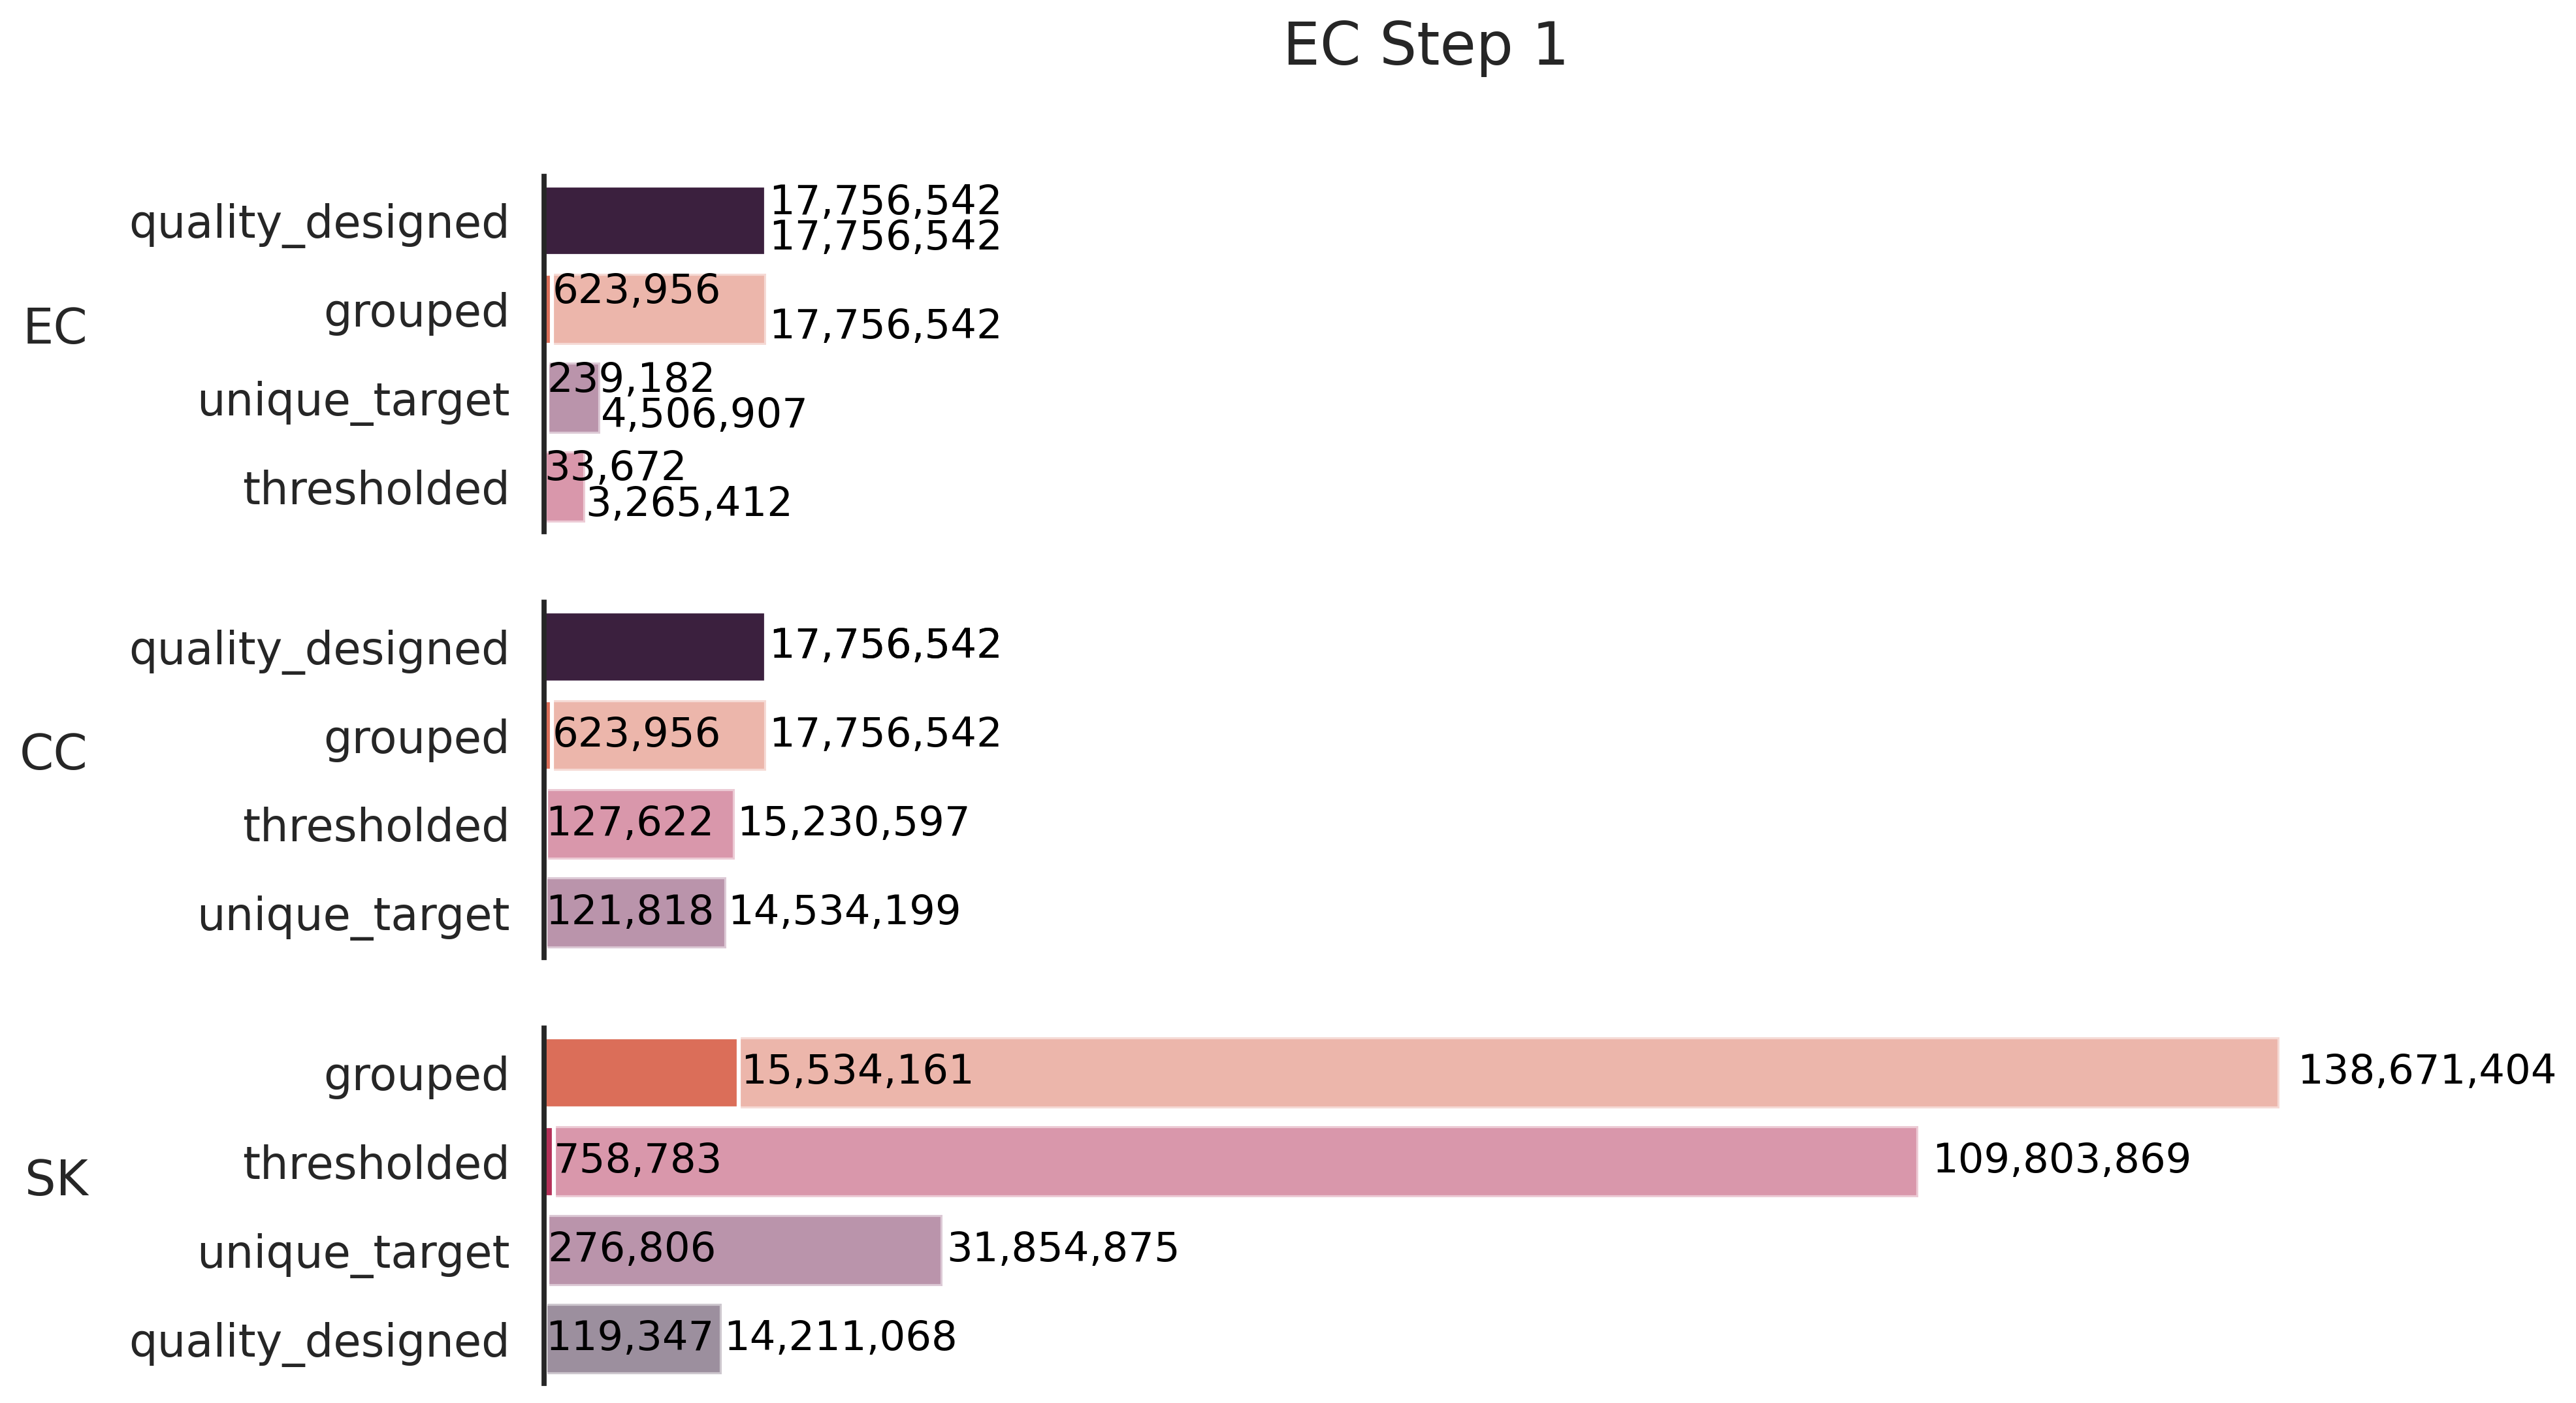

In [20]:
fig, axs = plt.subplots(3,1, figsize = (12, 8), dpi = 300, sharex = True)

sns.set_context('talk')

EC_threshold_last_refiner.plot_loss(ax = axs[0], text_offset = 0.2)
axs[0].set_ylabel("EC", rotation = 0, ha = 'right', labelpad = 15)

EC_threshold_first_refiner.plot_loss(ax = axs[1])
axs[1].set_ylabel("CC", rotation = 0, ha = 'right', labelpad = 15)

EC_sk_order_refiner.plot_loss(ax = axs[2])
axs[2].set_ylabel("SK", rotation = 0, ha = 'right', labelpad = 15)

fig.suptitle("EC Step 1")


for ax in axs:
    ax.set_xlabel("")